In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My\ Drive/CPM_Pytorch

/content/drive/My Drive/CPM_Pytorch


In [ ]:
import matplotlib
matplotlib.use('TKAgg')

from data_loader.dataLoader import CarDataset as Mydata
from model.cpm import CPM
from src.util import heatmap_image,save_images,PCK

import os
import glob

import torch
import torch.optim as optim
import torch.nn as nn
import configparser
import pandas as pd
import numpy as np

import cv2

from torch.autograd import Variable
from torch.utils.data import DataLoader

from torchvision import transforms
from PIL import Image, ImageDraw
from src.compute_origin import HumanSortKey,GetIntrinsicMatrix,DrawOrigin

In [ ]:
#Hyperparams
config = configparser.ConfigParser()
config.read('conf_online.text')

train_data_dir = config.get('data', 'train_data_dir')
model_save_dir=config.get('data', 'model_save_dir')
annotation_save_dir=config.get('data', 'annotation_save_dir')
keypoints_dir=config.get('data','keypoints_file_dir')

save_dir = config.get('data', 'save_dir')

learning_rate = config.getfloat('training', 'learning_rate')
batch_size = config.getint('training', 'batch_size')
epochs = config.getint('training', 'epochs')
begin_epoch = config.getint('training', 'begin_epoch')
n_keypoints=config.getint('training', 'n_keypoints')  

print(train_data_dir)


/content/drive//My Drive/Final Data/mustang/


In [ ]:
cuda = torch.cuda.is_available()
 

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [ ]:
# *********************** Build dataset ***********************
train_data = Mydata(data_dir=train_data_dir,n_keypoints=4)


print ('Train dataset total number of images sequence is ----' + str(len(train_data)))

# Data Loader
train_dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True)

Train dataset total number of images sequence is ----528


In [ ]:
train_data.images_dir.sort(key=HumanSortKey)
train_data.label_dir.sort(key=HumanSortKey)
train_data.label_dir[0:10]
begin_epoch=50

In [ ]:
net = CPM(out_c=n_keypoints)

device_ids = [0]  
if cuda:
    net = net.cuda(device_ids[0])
    net = nn.DataParallel(net, device_ids=device_ids)
print(model_save_dir)
if begin_epoch > 0:
    save_path =model_save_dir+'model_epoch' + str(begin_epoch) + '.pth'
    state_dict = torch.load(save_path)
    net.load_state_dict(state_dict)

models/


In [ ]:
def train():
    # *********************** initialize optimizer ***********************
    optimizer = optim.Adam(params=net.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    criterion = nn.MSELoss(size_average=True)                       # loss function MSE average

    net.train()
    for epoch in range(begin_epoch, epochs + 1):
        print ('epoch....................' + str(epoch))
        
        for step, (image, label_map, center_map, imgs) in enumerate(train_dataset):
            
            image = Variable(image.cuda() if cuda else image)                   # 4D Tensor
            # Batch_size  *  3  *  width(368)  *  height(368)

            # 4D Tensor to 5D Tensor
            label_map = torch.stack([label_map]*6, dim=1)
            # Batch_size  *  21 *   45  *  45
            # Batch_size  *   6 *   21  *  45  *  45
            label_map = Variable(label_map.cuda() if cuda else label_map)

            center_map = Variable(center_map.cuda() if cuda else center_map)    # 4D Tensor
            # Batch_size  *  width(368) * height(368)

            optimizer.zero_grad()
            pred_6 = net(image, center_map)  # 5D tensor:  batch size * stages * 21 * 45 * 45 #This is huge

            # ******************** calculate loss of each joints ********************
            loss = criterion(pred_6, label_map)

            # backward
            loss.backward()
            loss=loss.detach()
            #import ipdb
            #ipdb.set_trace()
            
            optimizer.step() #Not using SGD
            #gc.collect()

            if step % 10 == 0:
                print ('--step .....' + str(step))
                print ('--loss ',loss.item()*10000)
                gb_factor=10**9
                print('--gpu memory=',torch.cuda.memory_allocated()/gb_factor)

            #if step % 40 == 0:
              #torch.save(net.state_dict(), os.path.join(save_dir, 'model_epoch{:d}.pth'.format(epoch)))
            #    save_images(label_map[:, 5, :, :, :], pred_6[:, 5, :, :, :], step, epoch, imgs)

        if epoch % 50 == 0 and epoch>0:
            torch.save(net.state_dict(), os.path.join(save_dir, 'model_epoch{:d}.pth'.format(epoch)))
        
            #Delete tensors from memory
            #del image,label_map,center_map,pred_6

    print ('train done!')

In [ ]:
train()

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


epoch....................50
--step .....0
--loss  1.5840564446989447
--gpu memory= 4.405126144


ValueError: ignored

In [ ]:
!nvidia-smi

Wed Nov  4 08:21:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    38W / 250W |  14967MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def get_locations(pred_6):
  locations=[]
  label_locations=[]
  for keypoint_map in pred_6:
    
    flat_tensor=keypoint_map.view(1,-1)
    val=torch.argmax(flat_tensor).cpu().numpy()
    locations.append(np.array([val//45*(368/45),(val%45)*(368/45)]) ) #return values corresponding to a 368x368 image
  return np.array(locations)  #x y locations of the heatmap


In [ ]:
def generate_output_image(output,locations,colors=['red','blue','green','yellow']):
  
  output_image=transforms.ToPILImage()(output.cpu()).resize((368,368))
  draw = ImageDraw.Draw(output_image)

  i=0
  for x,y in locations:
    draw.ellipse((y, x, y+5, x+5), fill = colors[i], outline =colors[i])
    i+=1
  output_image.putalpha(150)
  return output_image

#output_image=generate_output_image(output.clone(),locations)
#output_image

/content/drive//My Drive/Final Data/mustang/Labels/labels528.txt


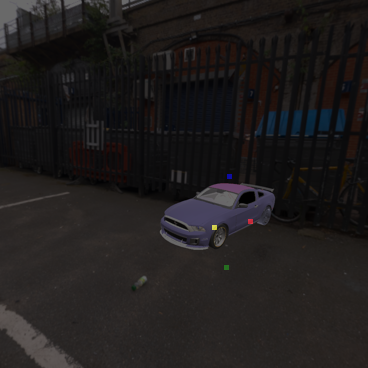

In [168]:
#Read the 3d keypoints
keypoints_3d=pd.read_csv(keypoints_dir)

usable_object_points=keypoints_3d.to_numpy()[0:n_keypoints] #Only use the first n_keypoints keypoints

def GetFOV(train_data_dir,i):
  #returns fov in degrees
  fov_dir=sorted(glob.glob(train_data_dir+"FOV_Labels/*.txt"),key=HumanSortKey)
  fov_file=pd.read_csv(fov_dir[i]) #This value is in degrees
  fov=fov_file['FOV'][0] #FOV in degrees
  return fov

def calculate_angle(rvec_pred,rvec_gt):
  #Returns the angle between the frames IN DEGREES
  R_pred,J_pred=cv2.Rodrigues(rvec_pred)
  R_gt,J_gt=cv2.Rodrigues(rvec_gt)

  dR=np.matmul(R_pred,np.transpose(R_gt))
  theta=np.arccos((np.trace(dR)-1)/2)
  return theta*180/np.pi #Convert from radians to degrees

def calculate_distance(tvec_pred,tvec_gt):
  #returns the distance between the objects IN CENTIMETERS
  dt=tvec_pred-tvec_gt
  return np.sum(np.sqrt(dt*dt))

#Function to save a prediction from an image
def predict_output(net,train_data,i):
  image,labels,center_map,img_str=train_data[i]
  pred_6=net(torch.unsqueeze(image,dim=0),torch.unsqueeze(center_map,dim=0))[0][-1] #Final stage output
  locations=get_locations(pred_6.detach()) #Get locations from the heatmap
  
  locations_original_size=900/368*locations #Convert from 368x368 to 900x900, since the image labels are in the same order too
  fov=GetFOV(train_data_dir,i)

  empty_image=np.zeros((900,900,3))
  camera_matrix=GetIntrinsicMatrix(empty_image,fov) #This is the same regardless of whether we use labels or predictions

  ret_val,rvec_pred,tvec_pred=cv2.solvePnP(objectPoints=usable_object_points,imagePoints=locations_original_size,cameraMatrix=camera_matrix
                                             ,distCoeffs=np.zeros((4,1)))
  
  usable_labels=pd.read_csv(train_data.label_dir[i],delimiter=" ").to_numpy()[0:n_keypoints]
  ret_val,rvec_gt,tvec_gt=cv2.solvePnP(objectPoints=usable_object_points,imagePoints=usable_labels,cameraMatrix=camera_matrix
                                             ,distCoeffs=np.zeros((4,1)))
  
  background=transforms.ToPILImage()(image)
  output=pred_6.clone().detach()*0

  output_image=generate_output_image(output,usable_labels*368/900)
  background.paste(output_image,(0,0),output_image)
  background.show()
  print(train_data.label_dir[i])
  return background
 

  #return calculate_distance(tvec_pred,tvec_gt)
  #print(rvec_pred)
  #print(rvec_gt)
  return calculate_angle(rvec_pred,rvec_gt)
  #return (rvec_gt,tvec_gt,rvec_pred,tvec_pred)

display(predict_output(net,train_data,527))

In [ ]:
#Prediction
i=0
for image,labels,center_map,img_str in train_data:
  pred_6=net(torch.unsqueeze(image,dim=0),torch.unsqueeze(center_map,dim=0))[0][-1] #Final stage output
  output=pred_6.clone().detach()*0
  pil_image=transforms.ToPILImage()(image)
  background=pil_image

  import ipdb
  ipdb.set_trace()
  output_image=generate_output_image(output,get_locations(pred_6))
  background.paste(output_image,(0,0),output_image)
  background.save(annotation_save_dir+'Image'+str(i)+'.PNG')
  i+=1
  #import ipdb
  #ipdb.set_trace()
  print("Saving Image ",i)

ValueError: ignored

In [ ]:
train_data.label_dir

['/content/drive//My Drive/Final Data/mustang/Labels/labels1.txt',
 '/content/drive//My Drive/Final Data/mustang/Labels/labels2.txt',
 '/content/drive//My Drive/Final Data/mustang/Labels/labels3.txt',
 '/content/drive//My Drive/Final Data/mustang/Labels/labels4.txt',
 '/content/drive//My Drive/Final Data/mustang/Labels/labels5.txt',
 '/content/drive//My Drive/Final Data/mustang/Labels/labels6.txt',
 '/content/drive//My Drive/Final Data/mustang/Labels/labels7.txt',
 '/content/drive//My Drive/Final Data/mustang/Labels/labels8.txt',
 '/content/drive//My Drive/Final Data/mustang/Labels/labels9.txt',
 '/content/drive//My Drive/Final Data/mustang/Labels/labels10.txt',
 '/content/drive//My Drive/Final Data/mustang/Labels/labels11.txt',
 '/content/drive//My Drive/Final Data/mustang/Labels/labels12.txt',
 '/content/drive//My Drive/Final Data/mustang/Labels/labels13.txt',
 '/content/drive//My Drive/Final Data/mustang/Labels/labels14.txt',
 '/content/drive//My Drive/Final Data/mustang/Labels/labe

In [ ]:
golf_annotation_save_dir='/content/drive/My Drive/Final Data/golf/Annotated_Images/'
golf_train_data_dir='/content/drive/My Drive/Final Data/golf/'

golf_train_data = Mydata(data_dir=golf_train_data_dir,n_keypoints=4)

golf_train_data.images_dir.sort(key=HumanSortKey)
golf_train_data.label_dir.sort(key=HumanSortKey)

#Predict on Golf using network trained on Mustang
i=0
for image,labels,center_map,img_str in golf_train_data:
  pred_6=net(torch.unsqueeze(image,dim=0),torch.unsqueeze(center_map,dim=0))[0][-1] #Final stage output
  output=pred_6.clone().detach()*0
  pil_image=transforms.ToPILImage()(image)
  background=pil_image

  output_image=generate_output_image(output,get_locations(pred_6))
  background.paste(output_image,(0,0),output_image)
  background.save(golf_annotation_save_dir+'Image'+str(i)+'.PNG')
  i+=1
  #import ipdb
  #ipdb.set_trace()
  print("Saving Image ",i)

['/content/drive/My Drive/Final Data/golf/Labels/labels1.txt',
 '/content/drive/My Drive/Final Data/golf/Labels/labels7.txt',
 '/content/drive/My Drive/Final Data/golf/Labels/labels3.txt',
 '/content/drive/My Drive/Final Data/golf/Labels/labels2.txt',
 '/content/drive/My Drive/Final Data/golf/Labels/labels4.txt',
 '/content/drive/My Drive/Final Data/golf/Labels/labels5.txt',
 '/content/drive/My Drive/Final Data/golf/Labels/labels6.txt',
 '/content/drive/My Drive/Final Data/golf/Labels/labels8.txt',
 '/content/drive/My Drive/Final Data/golf/Labels/labels13.txt',
 '/content/drive/My Drive/Final Data/golf/Labels/labels12.txt']